In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
import torchvision
import torch.nn.functional as F
import numpy as np
from numpy import nan
from pandas import read_csv

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from datetime import datetime
import holidays

from sympy import init_printing, Matrix
import seaborn as sns

from torch.utils.tensorboard import SummaryWriter

import os
import time
import sys
from tqdm import tqdm
#from tqdm.notebook import tqdm
import copy

In [2]:
%%bash
nvidia-smi

Tue Feb  4 20:40:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:07:00.0 Off |                    0 |
| N/A   36C    P0             72W /  400W |   81127MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [4]:
%%skip

# load all data
dataset = read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'Datetime':[0,1]}, index_col=['Datetime'])
# summarize
print(dataset.shape)
print(dataset.head())
# mark all missing values
dataset.replace('?', nan, inplace=True)
# add a column for for the remainder of sub metering
values = dataset.values.astype('float32')
dataset['Sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])
# save updated dataset
dataset.to_csv('household_power_consumption.csv')

/tmp/ipykernel_3855121/3936465141.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


                     Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

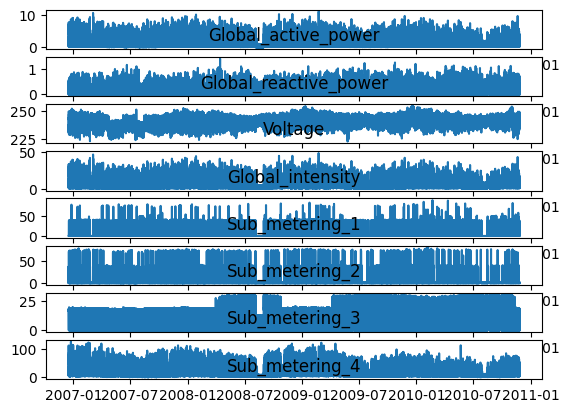

In [5]:
# load the new dataset and summarize
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])
print(dataset.head())

plt.figure()
for i in range(len(dataset.columns)):
	plt.subplot(len(dataset.columns), 1, i+1)
	name = dataset.columns[i]
	plt.plot(dataset[name])
	plt.title(name, y=0)
plt.show()

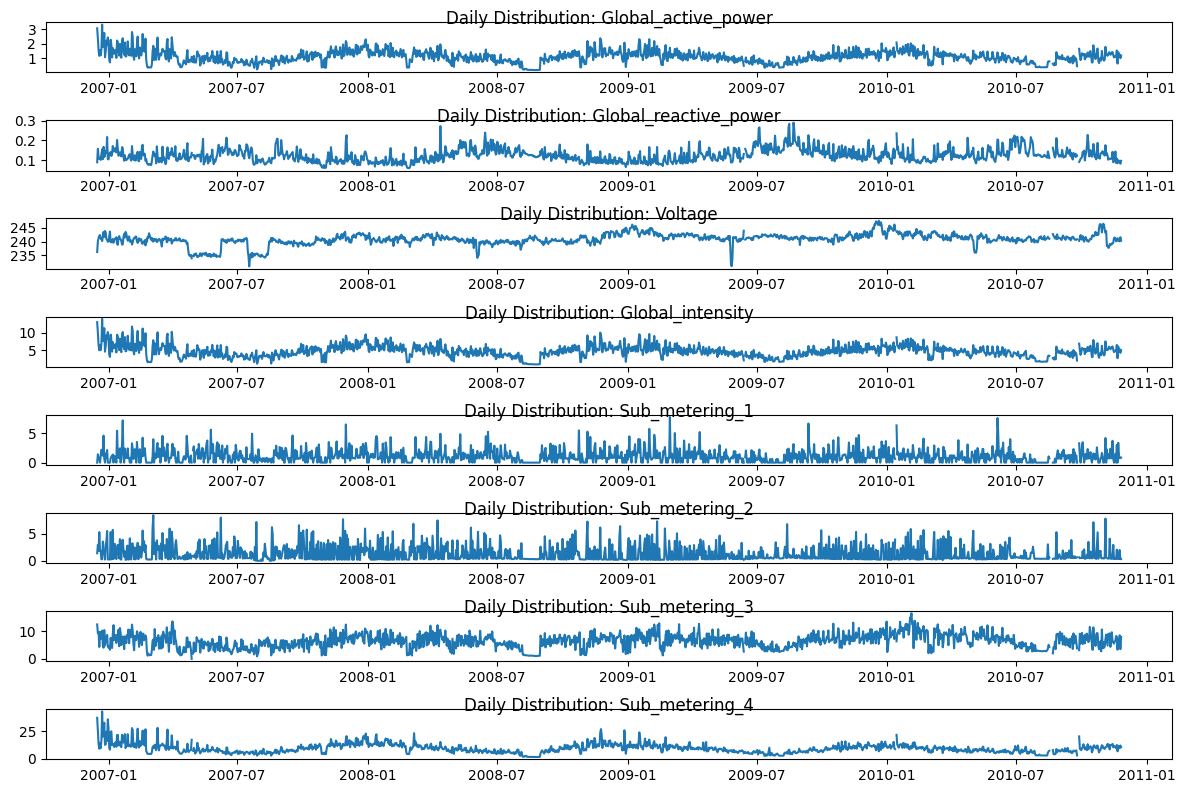

In [6]:
# Plot daily distribution
plt.figure(figsize=(12, 8))
daily_data = dataset.resample('D').mean()  # Resample by day and calculate the mean
for i in range(len(daily_data.columns)):
    plt.subplot(len(daily_data.columns), 1, i + 1)
    name = daily_data.columns[i]
    plt.plot(daily_data.index, daily_data[name])
    plt.title(f'Daily Distribution: {name}', y=0.8)
plt.tight_layout()
plt.show()

/tmp/ipykernel_3855121/1394378584.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_data = dataset.resample('H').mean()  # Resample by hour and calculate the mean


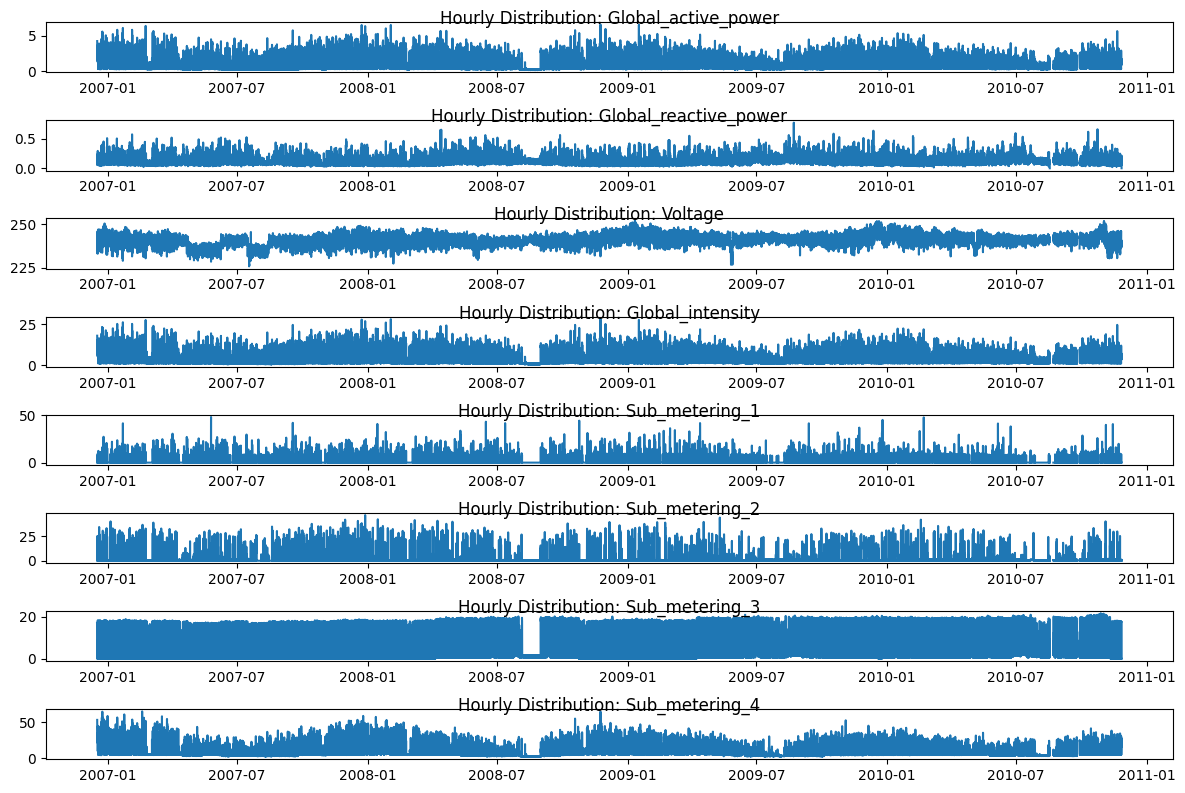

In [7]:
# Plot hourly distribution
plt.figure(figsize=(12, 8))
hourly_data = dataset.resample('H').mean()  # Resample by hour and calculate the mean
for i in range(len(hourly_data.columns)):
    plt.subplot(len(hourly_data.columns), 1, i + 1)
    name = hourly_data.columns[i]
    plt.plot(hourly_data.index, hourly_data[name])
    plt.title(f'Hourly Distribution: {name}', y=0.8)
plt.tight_layout()
plt.show()

/tmp/ipykernel_3855121/3936465141.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


                     Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

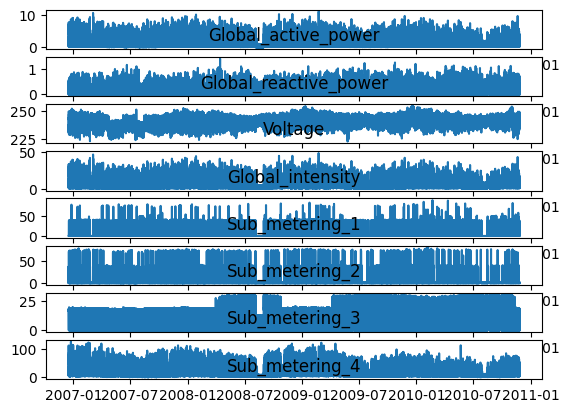

In [8]:
# load the new dataset and summarize
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])
print(dataset.head())

plt.figure()
for i in range(len(dataset.columns)):
	plt.subplot(len(dataset.columns), 1, i+1)
	name = dataset.columns[i]
	plt.plot(dataset[name])
	plt.title(name, y=0)
plt.show()

/tmp/ipykernel_3855121/1509532806.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


Matrix([
[  1.0,  0.247,   -0.4,  0.999,  0.484,  0.435,  0.639,  0.701],
[0.247,    1.0, -0.112,  0.266,  0.123,  0.139, 0.0896,  0.212],
[ -0.4, -0.112,    1.0, -0.411, -0.196, -0.167, -0.268, -0.271],
[0.999,  0.266, -0.411,    1.0,  0.489,   0.44,  0.627,  0.703],
[0.484,  0.123, -0.196,  0.489,    1.0, 0.0547,  0.103,  0.125],
[0.435,  0.139, -0.167,   0.44, 0.0547,    1.0, 0.0809, 0.0852],
[0.639, 0.0896, -0.268,  0.627,  0.103, 0.0809,    1.0,  0.179],
[0.701,  0.212, -0.271,  0.703,  0.125, 0.0852,  0.179,    1.0]])

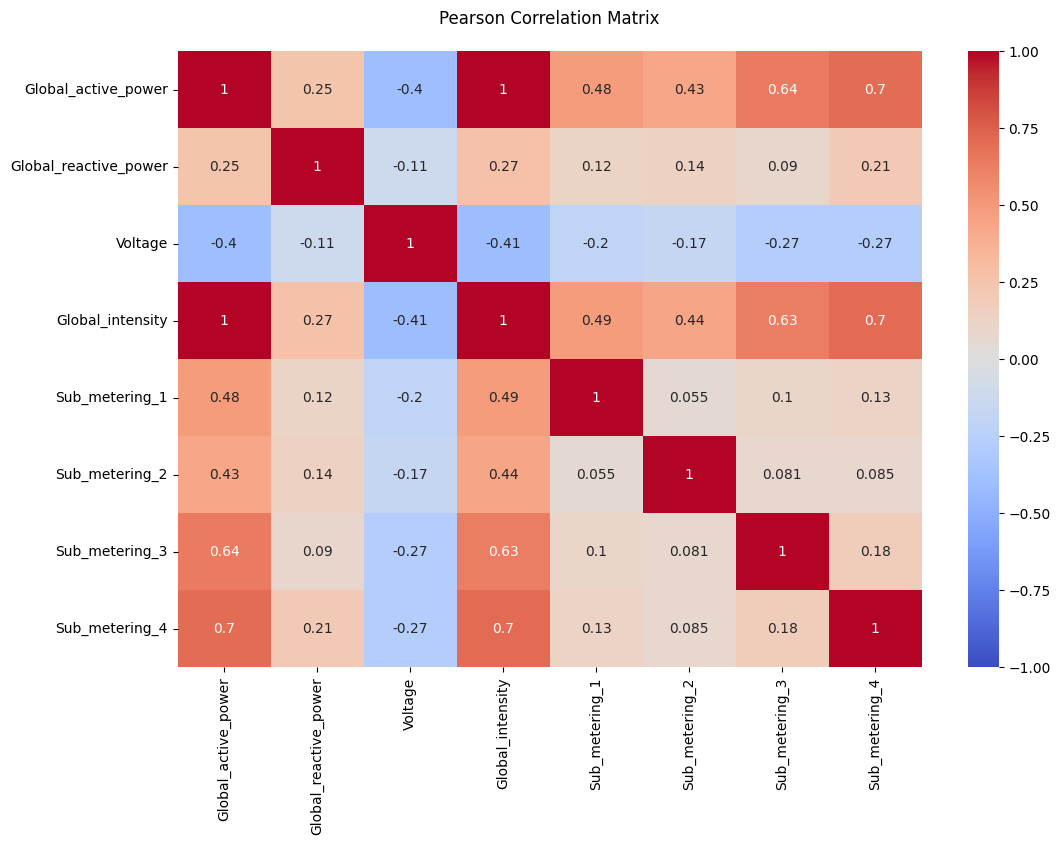

In [9]:
# load the new dataset and summarize
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])
#print(dataset.columns)
#plot the pearson correlation matrix of the dataset which shows the correlation between the variables and labels them accordingly
correlation = dataset.corr()
#pretty print the correlation matrix here
display(Matrix(correlation).evalf(3))
# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Pearson Correlation Matrix', pad=20)
plt.show()


/tmp/ipykernel_3855121/1481767106.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  datasetm = dataset.resample('M').mean()
/tmp/ipykernel_3855121/1481767106.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dataseth = dataset.resample('H').mean()


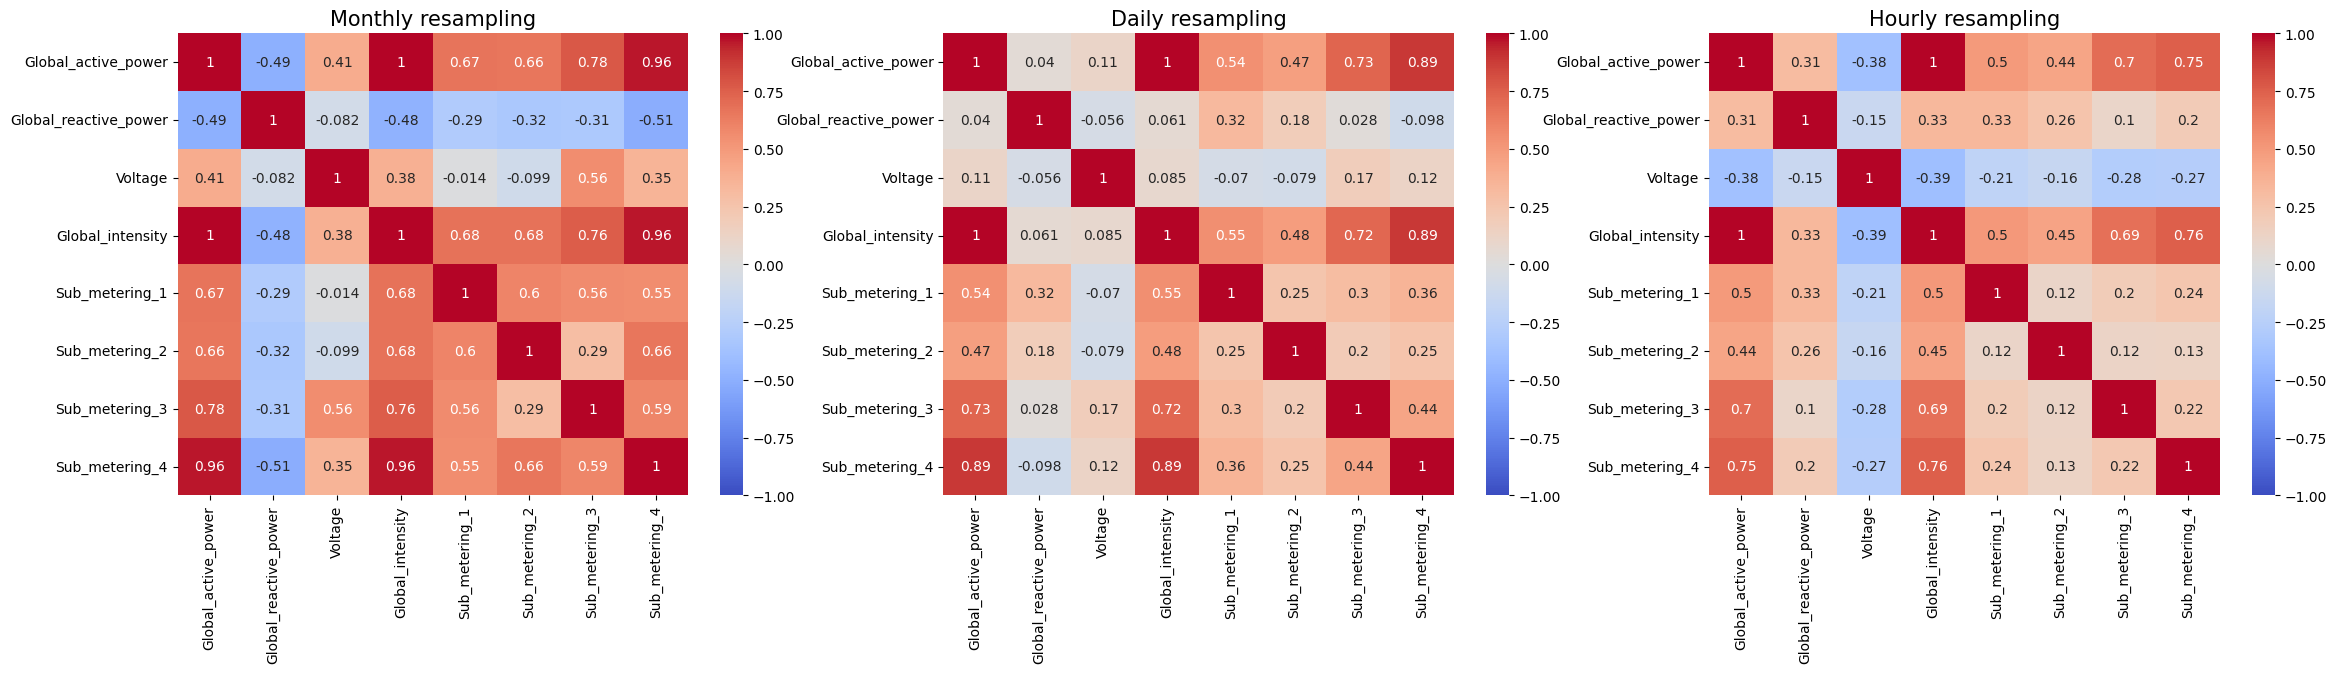

In [10]:
f= plt.figure(figsize=(28,6))

ax=f.add_subplot(131)
datasetm = dataset.resample('M').mean()
sns.heatmap(datasetm.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Monthly resampling', size=15)

ax=f.add_subplot(132)
datasetd = dataset.resample('D').mean()
sns.heatmap(datasetd.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Daily resampling', size=15)
  
ax=f.add_subplot(133)
dataseth = dataset.resample('H').mean()
sns.heatmap(dataseth.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Hourly resampling', size=15)
plt.show()

In [11]:
# load the new dataset and summarize
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])
#show number of missing values in each column
dataset.isnull().sum()

/tmp/ipykernel_3855121/721238349.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['Datetime'], index_col=['Datetime'])


Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
Sub_metering_4           25979
dtype: int64

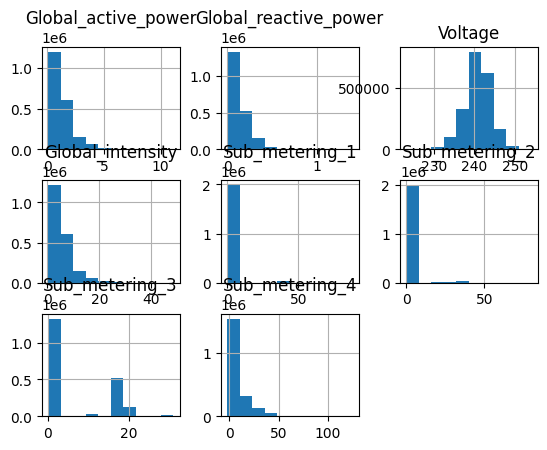

Since most of these distributions aren't normally distributed, we can't use the mean to fill in the missing values. We could use a median instead. Additionnally, normalization of the dataset can be done but standardization shoudl be avoided here as it will make the data more Gaussian-like and this is not the case for this dataset.


In [12]:
#show the distrbution of all values in the dataset
dataset.hist()
plt.show()
print("Since most of these distributions aren't normally distributed, we can't use the mean to fill in the missing values. We could use a median instead. Additionnally, normalization of the dataset can be done but standardization shoudl be avoided here as it will make the data more Gaussian-like and this is not the case for this dataset.")

In [13]:
%%skip
print("In any case, we will either use MinMaxScaler or RobustScaler to normalize the data. We will also use the median to fill in the missing values udring imputation of the dataset.")
#for the time, we will make a dumb LSTM model with no data processing for now for comparaison purposes

#we will create a sanatized version of the dataset, seperate from the original one and compare the two

# Load dataset
df = pd.read_csv("household_power_consumption.txt", sep=';', header=0, low_memory=False)
print(df.columns)

# Combine Date and Time manually
df = df.assign(Datetime=pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S", errors="coerce"))

# Drop original Date and Time columns (optional)
df.drop(columns=["Date", "Time"], inplace=True)

# Set index if needed
#df.set_index("Datetime", inplace=True)

print(df.head())

# Define numerical columns
numeric_cols = ["Global_active_power", "Global_reactive_power", "Voltage",
                "Global_intensity", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]

df.replace('?', nan, inplace=True)

for col in numeric_cols:
    df[col] = df[col].astype(float)

# Add a column for the remainder of sub metering
df['Sub_metering_4'] = (df["Global_active_power"] * 1000 / 60) - (df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3'])

# Daily differencing
df["Global_active_power_daily_diff"] = df["Global_active_power"].diff(periods=24*60)

# Annual differencing
df["Global_active_power_annual_diff"] = df["Global_active_power"].diff(periods=24*60*365)

added_cols = ["Sub_metering_4", "Global_active_power_daily_diff", "Global_active_power_annual_diff"]

for col in added_cols:
    df[col] = df[col].astype(float)
    
# Ensure Datetime is sorted
df = df.sort_values("Datetime")

# Compute energy consumption at different time scales
df["Hourly_Consumption"] = df["Global_active_power"]
df["Daily_Consumption"] = df.groupby(df["Datetime"].dt.date)["Global_active_power"].transform("sum")
df["Monthly_Consumption"] = df.groupby(df["Datetime"].dt.to_period("M"))["Global_active_power"].transform("sum")

# Create target columns (future predictions), better to include them now for normalization and scaling later after splitting the data
df["Next_Day_Hourly_Consumption"] = df["Hourly_Consumption"].shift(-24)  # Next day's same hour
df["Next_Week_Daily_Consumption"] = df["Daily_Consumption"].shift(-7)    # Daily for next week
df["Next_Month_Daily_Consumption"] = df["Daily_Consumption"].shift(-30)  # Daily for next month
df["Next_Year_Monthly_Consumption"] = df["Monthly_Consumption"].shift(-365)  # Monthly for next year

# Impute missing values and create missing indicators
for col in numeric_cols + added_cols:
    df[f"{col}_was_missing"] = df[col].isna()  # Boolean flag for missing values
    #imputation should be done after splitting the data into training and testing sets
    #df.fillna({col: df[col].median()}, inplace=True)  # Median imputation

print(df.columns)

# Sort by datetime (in case it's unordered)
df.sort_values("Datetime", inplace=True)

# Create new time-based features
df["Hour"] = df["Datetime"].dt.hour
df["Weekday"] = df["Datetime"].dt.weekday  # 0=Monday, 6=Sunday
df["Is_Weekend"] = df["Weekday"] >= 5

# Add French holiday feature
fr_holidays = holidays.FR()
df["Is_Holiday"] = df["Datetime"].dt.date.astype(str).apply(lambda x: x in fr_holidays)

# add season feature
df["Season"] = df["Datetime"].dt.month.apply(lambda x: (x % 12 + 3) // 3)

#move datetime to front of the dataframe
cols = list(df)
cols.insert(0, cols.pop(cols.index('Datetime')))
df = df.loc[:, cols]

# Save the updated dataset
df.to_csv("household_power_consumption_processed_with_features.csv", index=False)

print("Dataset updated and saved as household_power_consumption_processed_with_features.csv")


Datetime                                            0
Global_active_power                             25979
Global_reactive_power                           25979
Voltage                                         25979
Global_intensity                                25979
Sub_metering_1                                  25979
Sub_metering_2                                  25979
Sub_metering_3                                  25979
Sub_metering_4                                  25979
Global_active_power_daily_diff                  37391
Global_active_power_annual_diff                555992
Hourly_Consumption                              25979
Daily_Consumption                                   0
Monthly_Consumption                                 0
Next_Day_Hourly_Consumption                     26003
Next_Week_Daily_Consumption                         7
Next_Month_Daily_Consumption                       30
Next_Year_Monthly_Consumption                     365
Global_active_power_was_miss

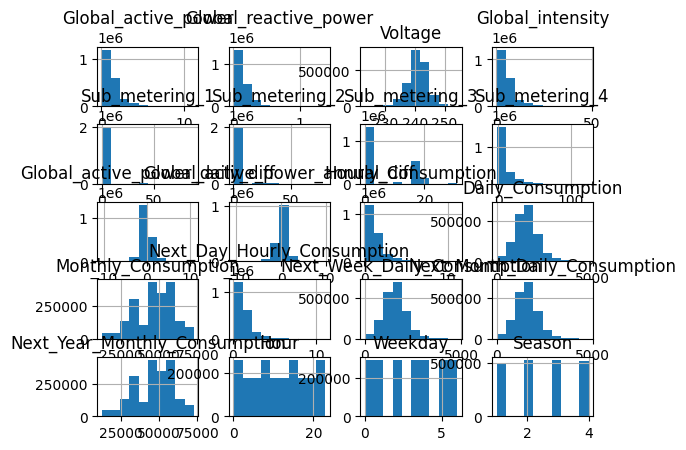

In [14]:
# load the new dataset and summarize
dataset = read_csv('household_power_consumption_processed_with_features.csv', header=0)
#show number of missing values in each column
print(dataset.isnull().sum())
mm_scaler = MinMaxScaler()
r_scaler = RobustScaler()
imputer = SimpleImputer(strategy='median')
# Apply winsorization (clipping the top and bottom 0.1%) which helps to reduce the effect of outliers, will be done after splitting and before the scaling
#lower_percentile = 0.1
#upper_percentile = 99.9
#
#for col in numeric_cols:
#    lower_limit = np.percentile(df[col], lower_percentile)
#    upper_limit = np.percentile(df[col], upper_percentile)
#    
#    # Clip values outside the 0.1% and 99.9% range
#    df[col] = np.clip(df[col], lower_limit, upper_limit)
dataset.hist()
plt.show()


Matrix([
[    1.0,   0.247,    -0.4,    0.999,   0.484,     0.435,   0.639,   0.701,     0.58,    0.557,     1.0,     0.392,     0.252,     0.282,   0.0658,    0.0846,   -0.0028,    -0.127],
[  0.247,     1.0,  -0.112,    0.266,   0.123,     0.139,  0.0896,   0.212,    0.182,    0.192,   0.247,    0.0112,    -0.104,     0.128,   0.0695,    0.0889,   0.00809,    0.0585],
[   -0.4,  -0.112,     1.0,   -0.411,  -0.196,    -0.167,  -0.268,  -0.271,    -0.21,   -0.221,    -0.4,    0.0752,      0.19,    -0.176,  -0.0214,   -0.0217,    0.0137,    -0.154],
[  0.999,   0.266,  -0.411,      1.0,   0.489,      0.44,   0.627,   0.703,    0.581,    0.558,   0.999,     0.386,     0.242,     0.282,   0.0672,    0.0865,  -0.00281,    -0.121],
[  0.484,   0.123,  -0.196,    0.489,     1.0,    0.0547,   0.103,   0.125,    0.349,    0.339,   0.484,    0.0972,     0.039,     0.108,    0.053,    0.0652,   0.00866,   -0.0126],
[  0.435,   0.139,  -0.167,     0.44,  0.0547,       1.0,  0.0809,  0.0852,    0.

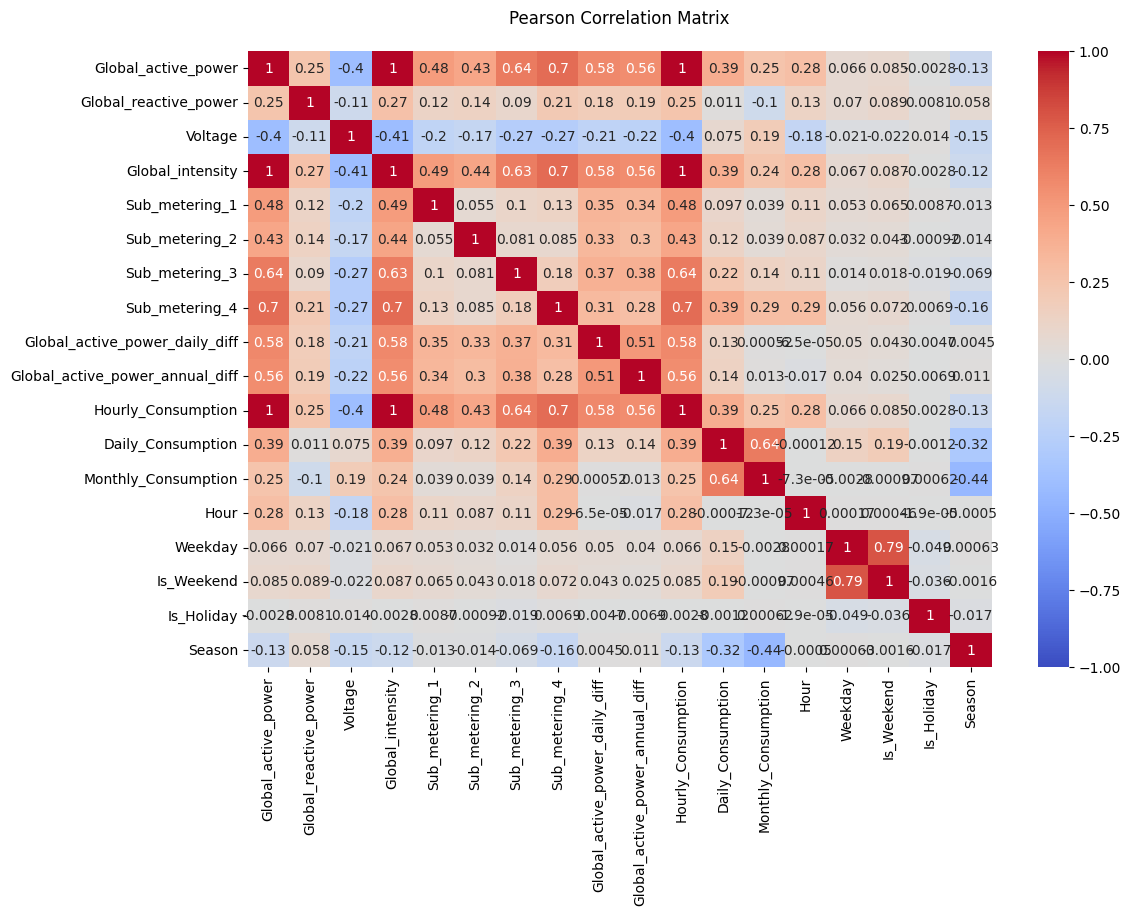

In [15]:
features = ["Next_Day_Hourly_Consumption", "Next_Week_Daily_Consumption",
                          "Next_Month_Daily_Consumption", "Next_Year_Monthly_Consumption", "Datetime"]

predictors = {"hourly":"Next_Day_Hourly_Consumption", "weekly":"Next_Week_Daily_Consumption",
              "monthly":"Next_Month_Daily_Consumption", "yearly":"Next_Year_Monthly_Consumption"}

dataset_copy = dataset.loc[:, ~dataset.columns.str.contains("was_missing")]
dataset_copy = dataset_copy.drop(columns=features)
correlation = dataset_copy.corr()
#pretty print the correlation matrix here
display(Matrix(correlation).evalf(3))
# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Pearson Correlation Matrix', pad=20)
plt.show()

In [75]:
def create_sliding_windows(X, y, window_size):
    """
    Create sliding windows for time series data.

    Args:
        X (np.ndarray): Input features of shape (n_samples, n_features).
        y (np.ndarray): Target values of shape (n_samples,).
        window_size (int): Size of the sliding window.

    Returns:
        X_windows (np.ndarray): Array of input windows with shape (n_windows, window_size, n_features).
        y_windows (np.ndarray): Array of target values with shape (n_windows,).
    """
    X_windows, y_windows = [], []

    for i in range(len(X) - window_size):
        X_windows.append(X[i:i + window_size])  # Window of input features
        y_windows.append(y[i + window_size])  # Corresponding target value

    return np.array(X_windows), np.array(y_windows)

In [4]:
def select_features(X, y, num_features=10):
    """
    Selects the top 'num_features' best features using SelectKBest.
    """
    selector = SelectKBest(score_func=f_regression, k=num_features)
    X_selected = selector.fit_transform(X, y)

    # Get selected feature names
    selected_features = X.columns[selector.get_support()]
    
    return pd.DataFrame(X_selected, columns=selected_features), selected_features

In [18]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

features = ["Datetime"]

predictors = {"hourly": "Next_Day_Hourly_Consumption", 
              "weekly": "Next_Week_Daily_Consumption", 
              "monthly": "Next_Month_Daily_Consumption", 
              "yearly": "Next_Year_Monthly_Consumption"}

X = dataset.drop(columns=features)
y = dataset[predictors["hourly"]]  # hourly consumption prediction

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio/(test_ratio + validation_ratio), shuffle=False)

# We perform the imputation and scaling after splitting the data to avoid data leakage

# Imputation and scaling minmax (mm)
mm_x_train = imputer.fit_transform(X_train)
mm_x_train = mm_scaler.fit_transform(mm_x_train)
mm_x_train = pd.DataFrame(mm_x_train, columns=X_train.columns)

mm_x_test = imputer.transform(X_test)
mm_x_test = mm_scaler.transform(mm_x_test)
mm_x_test = pd.DataFrame(mm_x_test, columns=X_test.columns)

# Imputation and scaling robust (r)
r_x_train = imputer.fit_transform(X_train)
r_x_train = r_scaler.fit_transform(r_x_train)
r_x_train = pd.DataFrame(r_x_train, columns=X_train.columns)

r_x_test = imputer.transform(X_test)
r_x_test = r_scaler.transform(r_x_test)
r_x_test = pd.DataFrame(r_x_test, columns=X_test.columns)

y_train = imputer.fit_transform(y_train.values.reshape(-1, 1)).ravel()  # Apply imputation to y_train
y_test = imputer.transform(y_test.values.reshape(-1, 1)).ravel()  # Apply imputation to y_test

X_selected, selected_features = select_features(mm_x_train, y_train, num_features=12)

print("Selected features:", selected_features)

X_selected, y_selected = create_sliding_windows(X_selected, y_train, window_size=60)

X_train, X_val, y_train, y_val = train_test_split(X_selected, y_selected, test_size=1 - train_ratio, shuffle=False)

print(X_train, X_val, X_test)


Selected features: Index(['Global_active_power', 'Voltage', 'Global_intensity', 'Sub_metering_3',
       'Sub_metering_4', 'Global_active_power_daily_diff',
       'Hourly_Consumption', 'Daily_Consumption', 'Monthly_Consumption',
       'Next_Week_Daily_Consumption', 'Next_Month_Daily_Consumption', 'Hour'],
      dtype='object')
[[[0.37479631 0.3727422  0.37759336 ... 0.2533162  0.2533162  0.73913043]
  [0.47836321 0.33300493 0.47302905 ... 0.2533162  0.2533162  0.73913043]
  [0.47963064 0.32183908 0.47302905 ... 0.2533162  0.2533162  0.73913043]
  ...
  [0.25927938 0.41215107 0.25311203 ... 0.2533162  0.2533162  0.7826087 ]
  [0.25873619 0.39474548 0.25311203 ... 0.2533162  0.2533162  0.7826087 ]
  [0.25801195 0.40032841 0.25311203 ... 0.2533162  0.2533162  0.7826087 ]]

 [[0.47836321 0.33300493 0.47302905 ... 0.2533162  0.2533162  0.73913043]
  [0.47963064 0.32183908 0.47302905 ... 0.2533162  0.2533162  0.73913043]
  [0.48089806 0.33661741 0.47302905 ... 0.2533162  0.2533162  0.73913

In [19]:
print(mm_x_train.isnull().sum())

Global_active_power                            0
Global_reactive_power                          0
Voltage                                        0
Global_intensity                               0
Sub_metering_1                                 0
Sub_metering_2                                 0
Sub_metering_3                                 0
Sub_metering_4                                 0
Global_active_power_daily_diff                 0
Global_active_power_annual_diff                0
Hourly_Consumption                             0
Daily_Consumption                              0
Monthly_Consumption                            0
Next_Day_Hourly_Consumption                    0
Next_Week_Daily_Consumption                    0
Next_Month_Daily_Consumption                   0
Next_Year_Monthly_Consumption                  0
Global_active_power_was_missing                0
Global_reactive_power_was_missing              0
Voltage_was_missing                            0
Global_intensity_was

In [20]:
print(r_x_train.isnull().sum())

Global_active_power                            0
Global_reactive_power                          0
Voltage                                        0
Global_intensity                               0
Sub_metering_1                                 0
Sub_metering_2                                 0
Sub_metering_3                                 0
Sub_metering_4                                 0
Global_active_power_daily_diff                 0
Global_active_power_annual_diff                0
Hourly_Consumption                             0
Daily_Consumption                              0
Monthly_Consumption                            0
Next_Day_Hourly_Consumption                    0
Next_Week_Daily_Consumption                    0
Next_Month_Daily_Consumption                   0
Next_Year_Monthly_Consumption                  0
Global_active_power_was_missing                0
Global_reactive_power_was_missing              0
Voltage_was_missing                            0
Global_intensity_was

In [1]:
#idea: could resample the data over 10 minutes, 1 hour, 1 day to reduce the number of samples and make the model more efficient with less computation

class LSTM(nn.Module):
    def __init__(self,
                 hidden_size,
                 in_size = 1,
                 num_layers = 1,
                 out_size = 1):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(
            input_size = in_size,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = True)
        self.fc = nn.Linear(hidden_size, out_size)

    #def forward(self, x):
    #    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    #    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    #    out, _ = self.lstm(x, (h0, c0))
    #    last_hidden_states = out[:, -1, :]
    #    out = self.fc(last_hidden_states)
    #    return out
    def forward(self, x, h = None):
        out, h = self.lstm(x, h)
        last_hidden_states = out[:, -1]
        out = self.fc(last_hidden_states)
        return out, h

class LSTM1(nn.Module):
    def __init__(self,
                 hidden_size,
                 in_size = 1,
                 num_layers = 1,
                 out_size = 1):
        super(LSTM1, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(
            input_size = in_size,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = True)
        self.fc = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        last_hidden_states = out[:, -1, :]
        out = self.fc(last_hidden_states)
        return out
        

class LSTM2(nn.Module):
    def __init__(self, hidden_size, in_size, out_size=1):
        super(LSTM2, self).__init__()
        self.lstm = nn.LSTM(input_size=in_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, out_size)  # Adjusted for single output

    def forward(self, x, h=None):
        out, h = self.lstm(x, h)
        last_hidden_states = out[:, -1, :]  # Correct indexing
        out = self.fc(last_hidden_states)
        return out, h

class GRU(nn.Module):
    def __init__(self, hidden_size, in_size = 1, out_size = 1):
        super(GRU, self).__init__()
        self.gru = nn.GRU(input_size = in_size, hidden_size = hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, out_size)
    def forward(self, x, h = None):
        out, _ = self.gru(x, h)
        last_hidden_states = out[:, -1, :]
        out = self.fc(last_hidden_states)
        return out, last_hidden_states
        
class CNN_LSTM(nn.Module):
    def __init__(self, hidden_size, in_size=1, out_size=1, num_layers = 1, conv_filters=64, kernel_size=3):
        super(CNN_LSTM, self).__init__()

        self.num_layers = num_layers
        
        # CNN
        self.conv1d = nn.Conv1d(in_channels=in_size, out_channels=conv_filters, kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)  # Reduce sequence length by half

        # LSTM
        self.lstm = nn.LSTM(input_size=conv_filters, hidden_size=hidden_size, batch_first=True)

        # output
        self.fc = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        # CNN expects (batch, channels, sequence_length), so we swap dimensions
        x = x.permute(0, 2, 1)  # (batch, in_size, seq_len) -> (batch, seq_len, in_size)
        
        x = self.conv1d(x)  # (batch, conv_filters, seq_len)
        x = self.relu(x)
        x = self.pool(x)  # (batch, conv_filters, reduced_seq_len)

        # Swap dimensions back for LSTM
        x = x.permute(0, 2, 1)  # (batch, reduced_seq_len, conv_filters)

        # LSTM processing
        self.lstm.flatten_parameters()
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        last_hidden_state = out[:, -1, :]  # Get last time step's hidden state

        out = self.fc(last_hidden_state)
        return out

NameError: name 'nn' is not defined

In [7]:
# size of LSTM hidden state
LSTM_HIDDEN_SIZE = 24

# size of CNN LSTM hidden state
CNN_LSTM_HIDDEN_SIZE = 50

# Optimizer learning rate
LEARNING_RATE = 0.02

TRAINING_EPOCHS = 100

BATCH_SIZE = 64

In [23]:
# Initializing the model
lstm_model = LSTM(hidden_size = LSTM_HIDDEN_SIZE)
lstm_model.train()

LSTM(
  (lstm): LSTM(1, 24, batch_first=True)
  (fc): Linear(in_features=24, out_features=1, bias=True)
)

In [24]:
cnn_lstm_model = CNN_LSTM(hidden_size=CNN_LSTM_HIDDEN_SIZE, in_size=1, out_size=1)
cnn_lstm_model.train()

CNN_LSTM(
  (conv1d): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(64, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [12]:
def get_optimizer(model, learning_rate):
    return torch.optim.Adam(model.parameters(), lr=learning_rate)


In [1]:

def train_lstm_model(model, train_loader, val_loader, test_loader, scaler, optimizer, loss_fn, features, epochs=100, device="cpu", scaling=True):
    """
    Trains an LSTM model and evaluates it on validation and test sets using DataLoader.
    
    Parameters:
        model (torch.nn.Module): LSTM model
        train_loader (torch.utils.data.DataLoader): DataLoader for training data
        val_loader (torch.utils.data.DataLoader): DataLoader for validation data
        test_loader (torch.utils.data.DataLoader): DataLoader for test data
        scaler (sklearn.preprocessing.StandardScaler): Scaler for inverse transform
        optimizer (torch.optim.Optimizer): Optimizer for training
        loss_fn (callable): Loss function
        epochs (int): Number of training epochs (default=100)
        device (str): Device to train on ('cpu' or 'cuda')

    Returns:
        best_model (torch.nn.Module): The best trained model
        training_loss (list): Training loss history
        validation_loss (list): Validation loss history
    """

    model.to(device)
    
    best_model = None
    min_val_loss = sys.maxsize

    training_loss = []
    validation_loss = []
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    writer = SummaryWriter('runs/LSTM_trainer_{}'.format(timestamp))

    log_freq=20
    num_batches = len(train_loader)
    log_interval = max(1, num_batches // log_freq)
    
    for epoch in range(epochs):
        model.train(True)
        epoch_train_loss = 0.0
        running_loss = 0.0
        i = 0
        
        # Training loop over batches
        for x_batch, y_batch in tqdm(train_loader, desc="Epoch Progress", unit="batch", leave=False, total=len(train_loader)):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            y_pred, _ = model(x_batch)
            
            loss = loss_fn(y_pred, y_batch)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            running_loss += loss.item()

            if i % log_interval == (log_interval - 1):
                last_loss = running_loss / log_interval
                tb_x = epoch * num_batches + i + 1
                writer.add_scalar('Loss/train', last_loss, tb_x)
                running_loss = 0.0
            i += 1

        # Average training loss for the epoch
        epoch_train_loss /= len(train_loader)
        training_loss.append(epoch_train_loss)

        # Validation loop
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for x_val_batch, y_val_batch in tqdm(val_loader, desc="Validation Progress", unit="batch", leave=False, total=len(val_loader)):
                x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device)
                
                y_pred, _ = model(x_val_batch)
                
                val_loss = loss_fn(y_pred, y_val_batch)
                epoch_val_loss += val_loss.item()

        # Average validation loss for the epoch
        epoch_val_loss /= len(val_loader)
        validation_loss.append(epoch_val_loss)

        # Save the best model based on validation loss
        if epoch_val_loss < min_val_loss:
            best_model = copy.deepcopy(model)
            min_val_loss = epoch_val_loss

        if epoch % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}")
            print(f'Epoch {epoch}: Train Loss = {round(epoch_train_loss, 4)}, '
                      f'Val Loss = {round(epoch_val_loss, 4)}')

    # Evaluation on test set
    best_model.eval()
    predicted = []
    real = []
    
    with torch.no_grad():
        for x_test_batch, y_test_batch in tqdm(test_loader, desc="Test Progress", unit="batch", total=len(test_loader)):
            x_test_batch, y_test_batch = x_test_batch.to(device), y_test_batch.to(device)
            
            _, h_list = model(x_test_batch)
            h = tuple([h[-1].unsqueeze(0).to(device) for h in h_list])  # Ensure correct shape

            y_pred, _ = model(x_test_batch, h)

            predicted.extend(y_pred.cpu().numpy())
            real.extend(y_test_batch.cpu().numpy())

    print(len(test_loader))

    print(len(predicted), len(real))
    
    predicted = np.array(predicted).reshape(-1, 1)
    real = np.array(real).reshape(-1, 1)

    print(predicted.shape, real.shape)

    # Convert back to original scale (if needed)
    predicted = scaler.inverse_transform(np.hstack([np.zeros((predicted.shape[0], len(features))), predicted]))[:, -1]
    real = scaler.inverse_transform(np.hstack([np.zeros((real.shape[0], len(features))), real]))[:, -1]

    print(predicted.shape, real.shape)

    # Plot test predictions
    plt.figure(figsize=(10, 4))
    plt.title("Test Dataset Predictions")
    plt.plot(real, label='Real')
    plt.plot(predicted, label='Predicted')
    plt.legend()
    plt.show()

    # Plot training and validation loss
    plt.figure(figsize=(10, 4))
    plt.title('Training Loss Curve')
    plt.yscale('log')
    plt.plot(training_loss, label='Training')
    plt.plot(validation_loss, label='Validation')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    return best_model, training_loss, validation_loss

In [2]:
def save_model(model, architecture_name, target_name, directory="models/"):
    """
    Saves a trained PyTorch model with a filename based on its architecture and target variable.
    """

    os.makedirs(directory, exist_ok=True)

    timestamp = time.strftime("%Y%m%d-%H%M%S")
    model_filename = f"{directory}{architecture_name}_{target_name}_{timestamp}.pth"

    # saves the model
    torch.save(model.state_dict(), model_filename)
    print(f"Model saved as {model_filename}")

    return model_filename


In [97]:
def load_torch_dataset(X_train, X_test, X_val, y_train, y_test, y_val, batch_size=64):
    """
    Loads the Pytorch dataset and dataloaders for training, validation and testing from sklearn train_test_split.
    """
    
    X_train = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
    X_test = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test
    X_val = X_val.to_numpy() if isinstance(X_val, pd.DataFrame) else X_val
    
    y_train = y_train.to_numpy() if isinstance(y_train, (pd.DataFrame, pd.Series)) else y_train
    y_test = y_test.to_numpy() if isinstance(y_test, (pd.DataFrame, pd.Series)) else y_test
    y_val = y_val.to_numpy() if isinstance(y_val, (pd.DataFrame, pd.Series)) else y_val
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [94]:
def load_torch_tensor(X_train, X_test, X_val, y_train, y_test, y_val):
    X_train = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
    X_test = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test
    X_val = X_val.to_numpy() if isinstance(X_val, pd.DataFrame) else X_val
    
    y_train = y_train.to_numpy() if isinstance(y_train, (pd.DataFrame, pd.Series)) else y_train
    y_test = y_test.to_numpy() if isinstance(y_test, (pd.DataFrame, pd.Series)) else y_test
    y_val = y_val.to_numpy() if isinstance(y_val, (pd.DataFrame, pd.Series)) else y_val
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    return (X_train_tensor, y_train_tensor), (X_val_tensor, y_val_tensor), (X_test_tensor, y_test_tensor)

In [4]:
def calculate_metrics(model, data_loader, device):
    model.to(device)
    
    model.eval()  # Set the model to evaluation mode
    total_mse = 0
    total_mae = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)

            # Calculate MSE and MAE
            mse = torch.mean((outputs - labels) ** 2)
            mae = torch.mean(torch.abs(outputs - labels))

            total_mse += mse.item() * inputs.size(0)
            total_mae += mae.item() * inputs.size(0)
            total_samples += inputs.size(0)

    # Average over all samples
    mse = total_mse / total_samples
    mae = total_mae / total_samples
    rmse = torch.sqrt(torch.tensor(mse)).item()  # Calculate RMSE

    return mse, mae, rmse

In [15]:
%reload_ext tensorboard
logs_base_dir = "./runs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

Using device:  cuda:2
Using scaler: minmax
Training for predictor: hourly
Selected features: Index(['Global_active_power', 'Global_intensity', 'Sub_metering_3',
       'Sub_metering_4', 'Global_active_power_daily_diff',
       'Hourly_Consumption', 'Daily_Consumption', 'Hour', 'Season'],
      dtype='object')
Length of X_train: 233421, X_val: 77807, X_test: 207466
Length of y_train: 233421, y_val: 77807, y_test: 207466
Original y_train sample: [[0.25538345]
 [0.2321496 ]
 [0.22799396]
 [0.21288251]
 [0.21156026]]
Training model: lstm for predictor: hourly using minmax scaler
Epoch 1/10


Epoch Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1824/1824 [00:03<00:00, 493.51batch/s]
                                                                                                                                                              

Epoch 0: Train Loss = 0.0212, Val Loss = 0.0319
Epoch 2/10


Epoch Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1824/1824 [00:03<00:00, 488.90batch/s]
                                                                                                                                                              

Epoch 1: Train Loss = 0.0102, Val Loss = 0.0388
Epoch 3/10


Epoch Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1824/1824 [00:03<00:00, 494.90batch/s]
                                                                                                                                                              

Epoch 2: Train Loss = 0.0115, Val Loss = 0.0123
Epoch 4/10


Epoch Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1824/1824 [00:03<00:00, 495.15batch/s]
                                                                                                                                                              

Epoch 3: Train Loss = 0.0134, Val Loss = 0.0352
Epoch 5/10


Epoch Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1824/1824 [00:03<00:00, 495.33batch/s]
                                                                                                                                                              

Epoch 4: Train Loss = 0.0121, Val Loss = 0.0091
Epoch 6/10


Epoch Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1824/1824 [00:03<00:00, 493.22batch/s]
                                                                                                                                                              

Epoch 5: Train Loss = 0.0121, Val Loss = 0.0542
Epoch 7/10


Epoch Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1824/1824 [00:03<00:00, 494.37batch/s]
                                                                                                                                                              

Epoch 6: Train Loss = 0.0124, Val Loss = 0.0366
Epoch 8/10


Epoch Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1824/1824 [00:03<00:00, 494.99batch/s]
                                                                                                                                                              

Epoch 7: Train Loss = 0.011, Val Loss = 0.015
Epoch 9/10


Epoch Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1824/1824 [00:03<00:00, 494.50batch/s]
                                                                                                                                                              

Epoch 8: Train Loss = 0.0117, Val Loss = 0.0354
Epoch 10/10


Epoch Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1824/1824 [00:03<00:00, 494.80batch/s]
                                                                                                                                                              

Epoch 9: Train Loss = 0.0108, Val Loss = 0.0192


Test Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1621/1621 [00:02<00:00, 674.75batch/s]


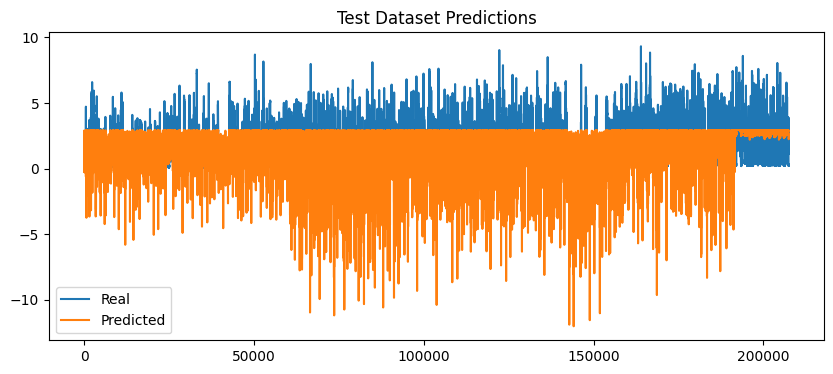

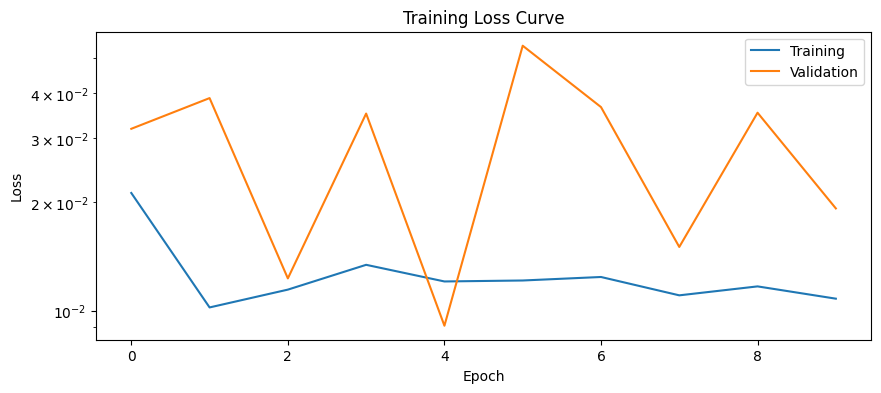

ValueError: too many values to unpack (expected 2)

In [108]:
# Training loop for each scaler, model, and predictor combination
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

dataset = read_csv('household_power_consumption_processed_with_features.csv', header=0)

dataset = dataset.head(len(dataset) // 4)

# Size of LSTM hidden state
LSTM_HIDDEN_SIZE = 64

# Size of CNN LSTM hidden state
CNN_LSTM_HIDDEN_SIZE = 50

# Optimizer learning rate
LEARNING_RATE = 0.09

TRAINING_EPOCHS = 10

BATCH_SIZE = 128

NUM_FEATURES = 9

LOSS = torch.nn.MSELoss()

mm_scaler = MinMaxScaler()
r_scaler = RobustScaler()

x_imputer = SimpleImputer(strategy='median')
y_imputer = SimpleImputer(strategy='median')

scalers = {
    "minmax": [MinMaxScaler(), MinMaxScaler()],
    "robust": [RobustScaler(), RobustScaler()]
}

models = {
    "lstm": LSTM1(hidden_size=LSTM_HIDDEN_SIZE, in_size=NUM_FEATURES, num_layers=1,out_size=1),
    "cnn_lstm": CNN_LSTM(hidden_size=CNN_LSTM_HIDDEN_SIZE, in_size=NUM_FEATURES, out_size=1)
}

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

features = ["Next_Day_Hourly_Consumption", "Next_Week_Daily_Consumption",
            "Next_Month_Daily_Consumption", "Next_Year_Monthly_Consumption", "Datetime", 
            "Global_active_power_annual_diff"] # features to drop

manual_selection_features = ['Global_active_power', 'Global_intensity', 'Sub_metering_3',
       'Sub_metering_4', 'Global_active_power_daily_diff',
       'Hourly_Consumption', 'Daily_Consumption', 'Hour', 'Season']

predictors = {
    "hourly": "Next_Day_Hourly_Consumption", 
    "weekly": "Next_Week_Daily_Consumption", 
    "monthly": "Next_Month_Daily_Consumption", 
    "yearly": "Next_Year_Monthly_Consumption"
}

sliding_window_size = {
    "hourly": 60,
    "weekly": 60*24*7,
    "monthly": 60*24*30,
    "yearly": 60*24*365
}

X = dataset.drop(columns=features)

print("Using device: ", device)
# Loop over scalers, models, and predictors
for scaler_name, scaler in scalers.items():
    print(f"Using scaler: {scaler_name}")

    x_scaler, y_scaler = scaler
    
    for predictor_key, predictor_column in predictors.items():
        print(f"Training for predictor: {predictor_key}")

        # Get target variable for the current predictor
        y = dataset[predictor_column]

        # Split data train, test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio/(test_ratio + validation_ratio), shuffle=False)

        # Imputation (using median) and scaling
        x_train_imputed = x_imputer.fit_transform(X_train)
        x_test_imputed = x_imputer.transform(X_test)
        
        if y_train.isnull().any():  # Check if y has missing values
            y_train_imputed = y_imputer.fit_transform(y_train.values.reshape(-1, 1)).ravel()
            y_test_imputed = y_imputer.transform(y_test.values.reshape(-1, 1)).ravel()
        else:
            y_train_imputed = y_train
            y_test_imputed = y_test

        x_train_imputed = pd.DataFrame(x_train_imputed, columns=X_train.columns)

        # Feature Selection
        X_selected, selected_features = select_features(x_train_imputed, y_train_imputed, num_features=NUM_FEATURES)
        
        #X_selected = X_train[manual_selection_features]
        #selected_features = manual_selection_features
        x_test_imputed = pd.DataFrame(x_test_imputed, columns=X_test.columns)
        X_test = x_test_imputed[selected_features]

        print("Selected features:", selected_features)

        # Scaling the dataset in parts to avoid data leakage
        x_train_scaled = x_scaler.fit_transform(X_selected)
        x_test_scaled = x_scaler.transform(X_test)
        y_train_scaled = y_scaler.fit_transform(y_train_imputed.reshape(-1, 1))
        y_test_scaled = y_scaler.transform(y_test_imputed.reshape(-1, 1))
        
        # Sliding Window Creation
        X_selected, y_selected = create_sliding_windows(x_train_scaled, y_train_scaled, window_size=sliding_window_size[predictor_key])
        X_test, y_test = create_sliding_windows(x_test_scaled, y_test_scaled, window_size=sliding_window_size[predictor_key])

        # Train-Validation Split
        X_train, X_val, y_train, y_val = train_test_split(X_selected, y_selected, test_size=1 - train_ratio, shuffle=False)

        # Load data into PyTorch DataLoader
        #print length of X_train, X_val, X_test
        print(f"Length of X_train: {len(X_train)}, X_val: {len(X_val)}, X_test: {len(X_test)}")
        #print length of y_train, y_val, y_test
        print(f"Length of y_train: {len(y_train)}, y_val: {len(y_val)}, y_test: {len(y_test)}")

        print("Original y_train sample:", y_train[:5])
        
        train_loader, val_loader, test_loader = load_torch_dataset(X_train, X_test, X_val, y_train, y_test, y_val, batch_size=BATCH_SIZE)
        
        # Loop over models
        for model_name, model in models.items():
            print(f"Training model: {model_name} for predictor: {predictor_key} using {scaler_name} scaler")

            opt = get_optimizer(model, LEARNING_RATE)
            
            #best_model, train_loss, val_loss = train_lstm_model(
            #    model, X_train, y_train, X_val, y_val, X_test, y_test, 
            #    scaler, opt, MSE_LOSS, 
            #    epochs=TRAINING_EPOCHS, device=device
            #)

            best_model, train_loss, val_loss = train_lstm_model(model, train_loader, val_loader, test_loader, 
                                                                y_scaler, opt, LOSS, epochs=TRAINING_EPOCHS, device=device)

            mse, mae, rmse = calculate_metrics(model, test_loader, device)
            print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}')

            save_model(best_model, model_name + f"_{scaler_name}_{predictor_key}", "consumption_prediction")


In [6]:
import torch

torch.cuda.empty_cache()  # Releases unused memory
torch.cuda.reset_peak_memory_stats()  # Resets memory tracking


Using device: cuda:1
Columns with all NaN values: []
Training for hourly (sampling for 24)
Datetime                                            0
Global_active_power                             25979
Global_reactive_power                           25979
Voltage                                         25979
Global_intensity                                25979
Sub_metering_1                                  25979
Sub_metering_2                                  25979
Sub_metering_3                                  25979
Sub_metering_4                                  25979
Global_active_power_daily_diff                  37391
Global_active_power_annual_diff                555992
Hourly_Consumption                              25979
Daily_Consumption                                   0
Monthly_Consumption                                 0
Global_active_power_was_missing                     0
Global_reactive_power_was_missing                   0
Voltage_was_missing                          

Epoch 1/50
Epoch 0: Train Loss = 0.0107, Val Loss = 0.0078


Epoch 11/50
Epoch 10: Train Loss = 0.0063, Val Loss = 0.0068


Epoch 21/50
Epoch 20: Train Loss = 0.006, Val Loss = 0.0062


Epoch 31/50
Epoch 30: Train Loss = 0.0058, Val Loss = 0.0059


Epoch 41/50
Epoch 40: Train Loss = 0.0057, Val Loss = 0.0057


Test Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 1105.13batch/s]


61
3872 3872
(3872, 1) (3872, 1)
(3872,) (3872,)


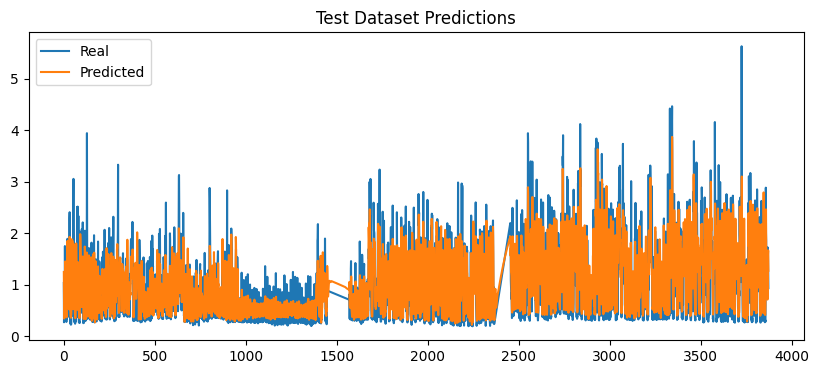

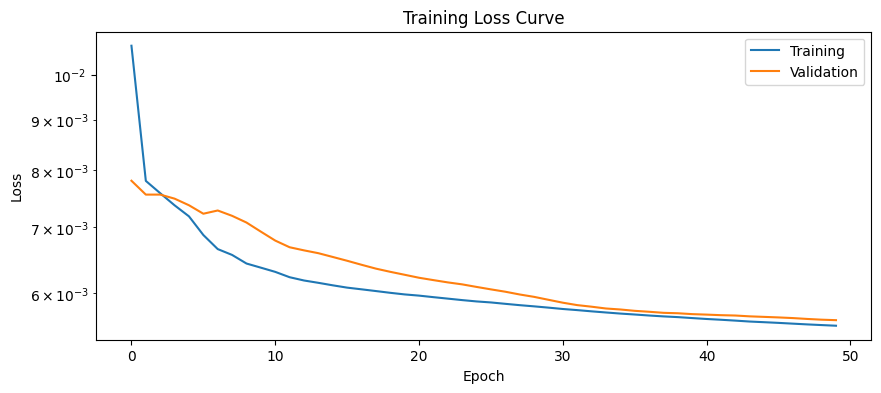

MSE: 0.0043, MAE: 0.0460, RMSE: 0.0653
Model saved as models/lstm_consumption_prediction_20250205-160200.pth
Training for weekly (sampling for 7)
Datetime                                            0
Global_active_power                             25979
Global_reactive_power                           25979
Voltage                                         25979
Global_intensity                                25979
Sub_metering_1                                  25979
Sub_metering_2                                  25979
Sub_metering_3                                  25979
Sub_metering_4                                  25979
Global_active_power_daily_diff                  37391
Global_active_power_annual_diff                555992
Hourly_Consumption                              25979
Daily_Consumption                                   0
Monthly_Consumption                                 0
Global_active_power_was_missing                     0
Global_reactive_power_was_missing           

Epoch 1/50
Epoch 0: Train Loss = 0.0513, Val Loss = 0.0193


Epoch 11/50
Epoch 10: Train Loss = 0.0148, Val Loss = 0.0135


Epoch 21/50
Epoch 20: Train Loss = 0.0141, Val Loss = 0.0134


Epoch 31/50
Epoch 30: Train Loss = 0.0138, Val Loss = 0.0134


Epoch 41/50
Epoch 40: Train Loss = 0.014, Val Loss = 0.0141


Test Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1015.82batch/s]


6
161 161
(161, 1) (161, 1)
(161,) (161,)


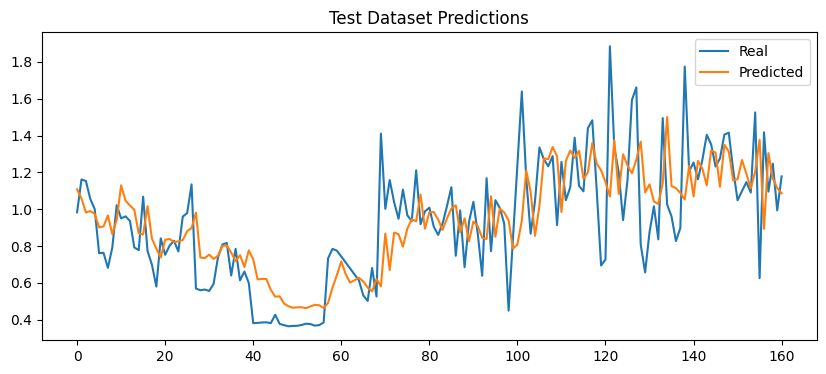

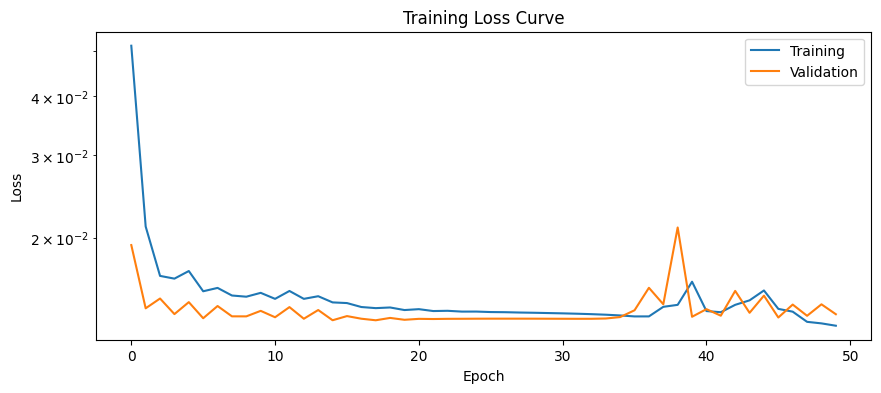

MSE: 0.0111, MAE: 0.0809, RMSE: 0.1054
Model saved as models/lstm_consumption_prediction_20250205-160203.pth
Training for monthly (sampling for 30)
Datetime                                            0
Global_active_power                             25979
Global_reactive_power                           25979
Voltage                                         25979
Global_intensity                                25979
Sub_metering_1                                  25979
Sub_metering_2                                  25979
Sub_metering_3                                  25979
Sub_metering_4                                  25979
Global_active_power_daily_diff                  37391
Global_active_power_annual_diff                555992
Hourly_Consumption                              25979
Daily_Consumption                                   0
Monthly_Consumption                                 0
Global_active_power_was_missing                     0
Global_reactive_power_was_missing         

Epoch 1/50
Epoch 0: Train Loss = 0.049, Val Loss = 0.0233


Epoch 11/50
Epoch 10: Train Loss = 0.0154, Val Loss = 0.0121


Epoch 21/50
Epoch 20: Train Loss = 0.0147, Val Loss = 0.0119


Epoch 31/50
Epoch 30: Train Loss = 0.0146, Val Loss = 0.0123


Epoch 41/50
Epoch 40: Train Loss = 0.0131, Val Loss = 0.0117


Test Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1369.93batch/s]


10
158 158
(158, 1) (158, 1)
(158,) (158,)


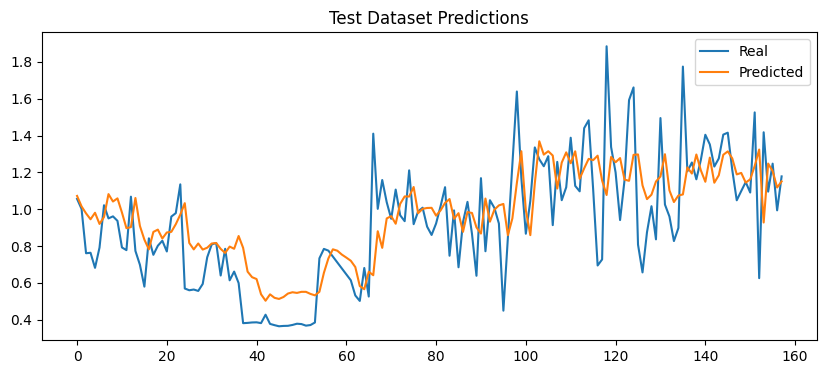

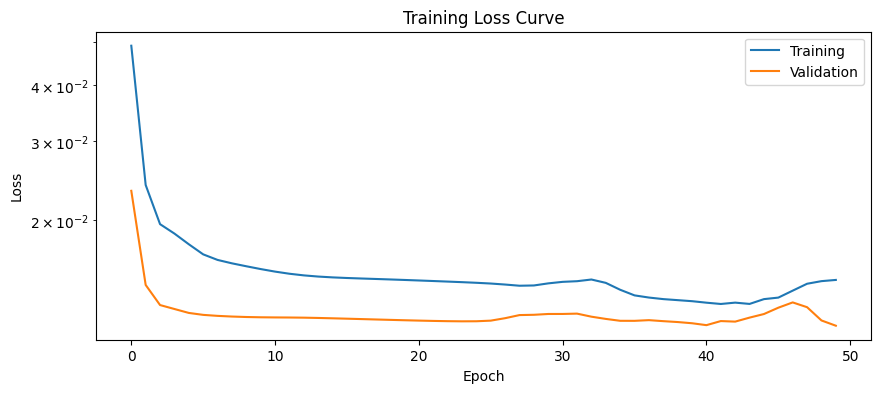

MSE: 0.0113, MAE: 0.0806, RMSE: 0.1062
Model saved as models/lstm_consumption_prediction_20250205-160208.pth
Training for yearly (sampling for 12)
Datetime                                            0
Global_active_power                             25979
Global_reactive_power                           25979
Voltage                                         25979
Global_intensity                                25979
Sub_metering_1                                  25979
Sub_metering_2                                  25979
Sub_metering_3                                  25979
Sub_metering_4                                  25979
Global_active_power_daily_diff                  37391
Global_active_power_annual_diff                555992
Hourly_Consumption                              25979
Daily_Consumption                                   0
Monthly_Consumption                                 0
Global_active_power_was_missing                     0
Global_reactive_power_was_missing          

Epoch 1/50
Epoch 0: Train Loss = 0.3223, Val Loss = 0.1046


Epoch 11/50
Epoch 10: Train Loss = 0.02, Val Loss = 0.008


Epoch 21/50
Epoch 20: Train Loss = 0.0115, Val Loss = 0.0025


Epoch 31/50
Epoch 30: Train Loss = 0.0047, Val Loss = 0.0177


Epoch 41/50
Epoch 40: Train Loss = 0.0037, Val Loss = 0.0178


Test Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1191.90batch/s]


1
5 5
(5, 1) (5, 1)
(5,) (5,)


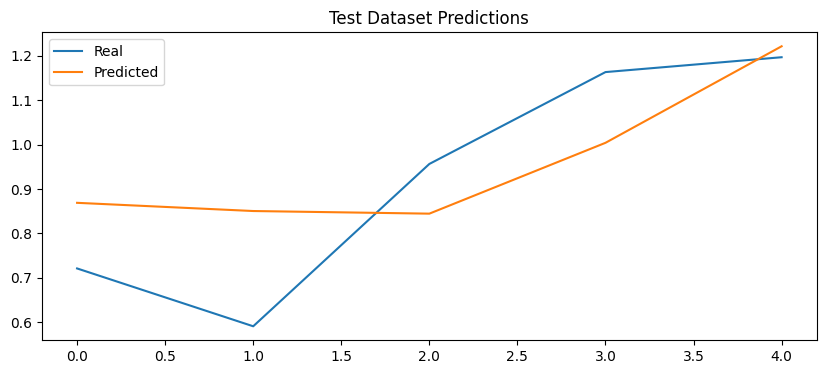

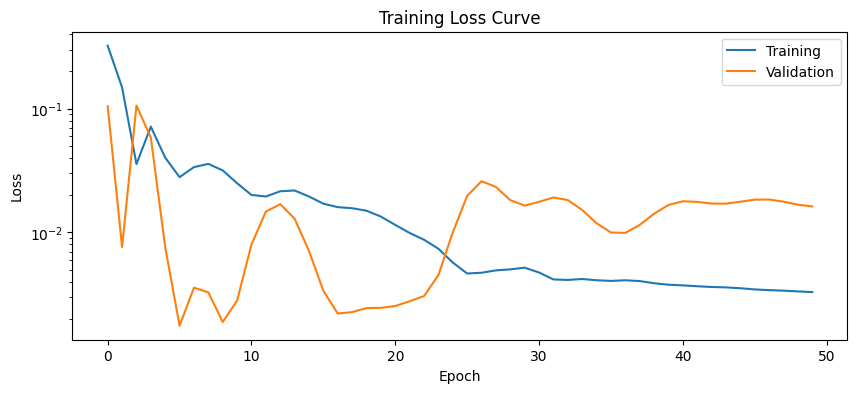

MSE: 0.0349, MAE: 0.1715, RMSE: 0.1868
Model saved as models/lstm_consumption_prediction_20250205-160209.pth


In [5]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
import torchvision
import torch.nn.functional as F
from torch.utils.data import *
import numpy as np
from numpy import nan
from pandas import read_csv

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from datetime import datetime
import holidays

from sympy import init_printing, Matrix
import seaborn as sns

from torch.utils.tensorboard import SummaryWriter

import os
import time
import sys
from tqdm import tqdm
#from tqdm.notebook import tqdm
import copy

#train_lstm_model
#save_model
#calculate_metrics

class LSTM2(nn.Module):
    def __init__(self, hidden_size, in_size, out_size=1):
        super(LSTM2, self).__init__()
        self.lstm = nn.LSTM(input_size=in_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, out_size)  # Adjusted for single output

    def forward(self, x, h=None):
        out, h = self.lstm(x, h)
        last_hidden_states = out[:, -1, :]  # Correct indexing
        out = self.fc(last_hidden_states)
        return out, h

def get_optimizer(model, learning_rate, regularization=0):
    return torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization)

def load_torch_dataset(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=64, num_workers=0):
    # Convert to PyTorch tensors
    X_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_torch = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)  # Ensure correct shape
    
    X_val_torch = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_torch = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)
    
    X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_torch = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)
    
    # Create DataLoader
    train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch), batch_size=batch_size, num_workers=num_workers, shuffle=False)
    val_loader = DataLoader(TensorDataset(X_val_torch, y_val_torch), batch_size=batch_size, num_workers=num_workers, shuffle=False)
    test_loader = DataLoader(TensorDataset(X_test_torch, y_test_torch), batch_size=batch_size, num_workers=num_workers, shuffle=False)

    return train_loader, val_loader, test_loader

def select_features(X, y, num_features=10):
    """
    Selects the top 'num_features' best features using SelectKBest.
    """
    selector = SelectKBest(score_func=f_regression, k=num_features)
    X_selected = selector.fit_transform(X, y)

    # Get selected feature names
    selected_features = X.columns[selector.get_support()]
    
    return selected_features

def create_sequences(data, target_col, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data.iloc[i:i+lookback, :-1].values)  # All selected features
        y.append(data.iloc[i+lookback, target_col])  # Target value
    return np.array(X), np.array(y)
    
import warnings
warnings.filterwarnings('ignore')
torch.cuda.empty_cache()

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dataset = read_csv('household_power_consumption_processed_with_features.csv', header=0)

missing_cols = dataset.columns[dataset.isna().all()]
print("Columns with all NaN values:", missing_cols.tolist())

features = ["Next_Day_Hourly_Consumption", "Next_Week_Daily_Consumption",
            "Next_Month_Daily_Consumption", "Next_Year_Monthly_Consumption"] # features to drop

dataset = dataset.drop(columns=features)

TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
# rest is TEST_RATIO

# Size of LSTM hidden state
LSTM_HIDDEN_SIZE = 128

# Size of CNN LSTM hidden state
CNN_LSTM_HIDDEN_SIZE = 50

# Optimizer learning rate
LEARNING_RATE = 0.002

TRAINING_EPOCHS = 50

BATCH_SIZE = 64

#default is 0
L2_REGULARIZATION = 1e-5
#L2_REGULARIZATION = 0

NUM_FEATURES = 9

LOSS = torch.nn.MSELoss()

DATASET_RATIO = len(dataset)

###################################
########### TEST PARAMETERS FOR LATER
sliding_window_range_size = {
    "hourly": [12, 24],
    "weekly": [7, 30],
    "monthly": [30, 90],
    "yearly": [12, 36]
}

sliding_window_minute_size = {
    "hourly": 60,
    "weekly": 60*24*7,
    "monthly": 60*24*30,
    "yearly": 60*24*365
}

batch_minute_sizes = {
    "hourly": 64,
    "weekly": 64,
    "monthly": 64,
    "yearly": 64
}

###################################

sampling_periods = {
    "hourly": "h",
    "weekly": "D",
    "monthly": "D",
    "yearly": "M"
}

sliding_window_size = {
    "hourly": 24,
    "weekly": 7,
    "monthly": 30,
    "yearly": 12
}

batch_sizes = {
    "hourly": 64,
    "weekly": 32,
    "monthly": 16,
    "yearly": 8
}

model_name = "lstm"
timestamp = "Datetime"
target = "Global_active_power"

#na_columns = ["Global_active_power_daily_diff", "Global_active_power_annual_diff"]
na_columns = []

for period_key, period_value in sampling_periods.items():
    print(f"Training for {period_key} (sampling for {sliding_window_size[period_key]})") 
    
    # Training loop for each scaler, model, and predictor combination
    df = dataset.head(DATASET_RATIO)
    
    df = df.drop(columns=na_columns) #NA columns, fix later in dataset

    print(df.isna().sum(), df.shape) 
    
    df[timestamp] = pd.to_datetime(df[timestamp])
    df = df.resample(period_value, on=timestamp).mean()   # Moyennes horaires

    df = df.interpolate()
    df.dropna(inplace=True)
    print(df.isna().sum(), df.shape) 
 
    selected_features = select_features(df.drop(columns=[target]), df[target], NUM_FEATURES).tolist()
    print(selected_features)
    #selected_features = ['Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
    input_size = len(selected_features)  # Number of selected input features
    #break
    #print(df.head())
    
    #df[selected_features] = df[selected_features].interpolate()  # Linear interpolation
    #df.dropna(inplace=True)  # Drop any remaining NaNs
    
    #print(df.head())
    
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df[selected_features + [target]])  # Include target
    df_scaled = pd.DataFrame(df_scaled, columns=selected_features + [target])
    
    #lookback = 24  # Example: use past 24 hours
    target_col = df_scaled.columns.get_loc(target)  # Target index
    
    X, y = create_sequences(df_scaled, target_col, lookback=sliding_window_size[period_key])
    
    train_size = int(len(X) * TRAIN_RATIO)
    val_size = int(len(X) * VAL_RATIO)
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]
    
    print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")
    
    train_loader, val_loader, test_loader = load_torch_dataset(X_train, y_train, 
                                                               X_val, y_val, 
                                                               X_test, y_test, 
                                                               batch_size=batch_sizes[period_key])
    
    model = LSTM2(LSTM_HIDDEN_SIZE, in_size=input_size).to(device)
    
    opt = get_optimizer(model, LEARNING_RATE, L2_REGULARIZATION)
    
    best_model, train_loss, val_loss = train_lstm_model(model, train_loader, val_loader, test_loader, 
                                                        scaler, opt, LOSS, features=selected_features, 
                                                        epochs=TRAINING_EPOCHS, device=device)
    
    mse, mae, rmse = calculate_metrics(best_model, test_loader, device)
    print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}')
    
    save_model(best_model, model_name, "consumption_prediction")

In [ ]:
#criterion = nn.MSELoss()  # Since we are predicting a continuous value
#optimizer = optim.Adam(model.parameters(), lr=0.001)
#
#num_epochs = 20
#
#for epoch in range(num_epochs):
#    model.train()
#    total_train_loss = 0
#
#    for X_batch, y_batch in train_loader:
#        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#        optimizer.zero_grad()
#        y_pred, _ = model(X_batch)  # Forward pass
#        loss = criterion(y_pred, y_batch)  # Compute loss
#        loss.backward()  # Backpropagation
#        optimizer.step()  # Update weights
#        total_train_loss += loss.item()
#
#    # Validation phase
#    model.eval()
#    total_val_loss = 0
#    with torch.no_grad():
#        for X_batch, y_batch in val_loader:
#            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#            y_pred, _ = model(X_batch)
#            val_loss = criterion(y_pred, y_batch)
#            total_val_loss += val_loss.item()
#
#    print(f"Epoch {epoch+1}: Train Loss: {total_train_loss/len(train_loader):.4f}, Validation Loss: {total_val_loss/len(val_loader):.4f}")
#
#model.eval()
#test_preds, test_actuals = [], []
#
#with torch.no_grad():
#    for X_batch, y_batch in test_loader:
#        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#        preds, _ = model(X_batch)
#        test_preds.extend(preds.cpu().numpy())
#        test_actuals.extend(y_batch.cpu().numpy())
#
## Convert to NumPy
#test_preds = np.array(test_preds).reshape(-1, 1)
#test_actuals = np.array(test_actuals).reshape(-1, 1)
#
## Convert back to original scale (if needed)
#test_preds = scaler.inverse_transform(np.hstack([np.zeros((test_preds.shape[0], len(selected_features))), test_preds]))[:, -1]
#test_actuals = scaler.inverse_transform(np.hstack([np.zeros((test_actuals.shape[0], len(selected_features))), test_actuals]))[:, -1]
#
## Plot Predictions vs Actual
#import matplotlib.pyplot as plt
#
#plt.figure(figsize=(10, 5))
#plt.plot(test_actuals[:100], label="Actual", linestyle="dashed")
#plt.plot(test_preds[:100], label="Predicted")
#plt.legend()
#plt.title("LSTM Predictions vs Actual Values")
#plt.show()